# data

In [41]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 날짜 범위 설정
date_range = pd.date_range(start="2024-07-01", end="2024-12-01", freq='MS')

# 모델별 데이터를 저장할 리스트
gemma_means, llama_means, qwen_means = [], [], []
gemma_vars, llama_vars, qwen_vars = [], [], []
dates = []  # 날짜 리스트 (X축)

for current_date in date_range:
    start_date = current_date.strftime('%Y-%m-%d')
    end_date = (current_date + pd.DateOffset(months=1) - timedelta(days=1)).strftime('%Y-%m-%d')

    # JSON 파일 로드
    with open(f'responses/gemma_{start_date}_{end_date}.json', 'r') as f:
        gemma_dict = json.load(f)
    with open(f'responses/llama_{start_date}_{end_date}.json', 'r') as f:
        llama_dict = json.load(f)
    with open(f'responses/qwen_{start_date}_{end_date}.json', 'r') as f:
        qwen_dict = json.load(f)
    
    sp500_tickers = gemma_dict.keys()
    
    # 기대 수익률 (View)
    gemma_means.append([np.mean(gemma_dict[ticker]['expected_return']) for ticker in sp500_tickers])
    llama_means.append([np.mean(llama_dict[ticker]['expected_return']) for ticker in sp500_tickers])
    qwen_means.append([np.mean(qwen_dict[ticker]['expected_return']) for ticker in sp500_tickers])

    # 수익률 분산 (Confidence)
    gemma_vars.append([np.var(gemma_dict[ticker]['expected_return']) for ticker in sp500_tickers])
    llama_vars.append([np.var(llama_dict[ticker]['expected_return']) for ticker in sp500_tickers])
    qwen_vars.append([np.var(qwen_dict[ticker]['expected_return']) for ticker in sp500_tickers])

    # X축 날짜 저장
    dates.append(start_date)

In [ ]:



gemma_means_df = pd.DataFrame(np.array(gemma_means), index=date_range, columns=sp500_tickers).T
llama_means_df = pd.DataFrame(np.array(llama_means), index=date_range, columns=sp500_tickers).T
qwen_means_df = pd.DataFrame(np.array(qwen_means), index=date_range, columns=sp500_tickers).T

gemma_vars_df = pd.DataFrame(np.array(gemma_vars), index=date_range, columns=sp500_tickers).T
llama_vars_df = pd.DataFrame(np.array(llama_vars), index=date_range, columns=sp500_tickers).T
qwen_vars_df = pd.DataFrame(np.array(qwen_vars), index=date_range, columns=sp500_tickers).T


In [44]:
np.array(gemma_means).shape

(6, 503)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import json
import matplotlib.pyplot as plt

"""
equal weight portfolio, optimized portfolio의 daily returns
"""
# read baselines results from responses_portfolios folder
equal_weighted_portfolio_returns = pd.read_csv('responses_portfolios/equal_weighted_portfolio.csv')
optimized_portfolio_returns = pd.read_csv('responses_portfolios/optimized_portfolio.csv')


In [2]:
equal_weighted_portfolio_returns

,Date,Portfolio_Return
0,2024-07-02,0.004299
1,2024-07-03,0.000922
2,2024-07-05,-0.000773
3,2024-07-08,0.002091
4,2024-07-09,-0.001719
...,...,...
113,2024-12-23,0.001926
114,2024-12-24,0.007830
115,2024-12-26,0.001076
116,2024-12-27,-0.007035


In [27]:
"""
llms의 월별 portfolio weights
"""

tau = 0.025

# read llm results from results folder
llama_results = pd.read_csv(f'results/llama_black_litterman_weights_tau_{tau}.csv', index_col='Date').T
qwen_results = pd.read_csv(f'results/qwen_black_litterman_weights_tau_{tau}.csv', index_col='Date').T
gemma_results = pd.read_csv(f'results/gemma_black_litterman_weights_tau_{tau}.csv', index_col='Date').T

In [40]:
import json
with open('market_caps.json', 'r') as f:
    market_caps = json.load(f)
market_caps_df = pd.DataFrame(list(market_caps.items()), columns=['Symbol', 'Market_Cap']).set_index('Symbol')
llama_results['Market_Cap']=market_caps_df['Market_Cap']
llama_results = llama_results.sort_values(by='Market_Cap', ascending=False)

llama_results

Date,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,Market_Cap
AAPL,0.000000e+00,2.201179e-17,0.000000e+00,0.000000e+00,0.000000e+00,6.781073e-18,0.000000e+00,3419480784896
NVDA,9.106173e-18,1.604768e-17,8.491530e-19,3.190304e-18,1.394592e-17,2.267351e-18,2.679170e-18,3179781554176
MSFT,0.000000e+00,1.445582e-18,1.290255e-18,0.000000e+00,6.377686e-19,3.527560e-18,0.000000e+00,3046073171968
AMZN,2.013301e-18,1.077926e-17,2.096282e-18,0.000000e+00,0.000000e+00,1.525969e-17,1.277761e-17,2428462694400
GOOGL,2.492754e-17,0.000000e+00,3.410209e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2269191602176
...,...,...,...,...,...,...,...,...
AES,2.032565e-17,0.000000e+00,5.864780e-18,0.000000e+00,0.000000e+00,3.751263e-01,1.129243e-17,7515555328
CE,0.000000e+00,9.075457e-18,1.318173e-17,7.836167e-19,0.000000e+00,1.997162e-01,7.718123e-18,7438682112
HII,4.046093e-18,0.000000e+00,1.097439e-17,0.000000e+00,6.523139e-19,0.000000e+00,8.073867e-18,6593047552
BWA,0.000000e+00,0.000000e+00,7.950619e-18,0.000000e+00,0.000000e+00,1.866910e-18,1.195291e-17,6564893696


In [36]:
import json
with open('market_caps.json', 'r') as f:
    market_caps = json.load(f)
market_caps_df = pd.DataFrame(list(market_caps.items()), columns=['Symbol', 'Market_Cap']).set_index('Symbol')

In [37]:
market_caps_df

,Market_Cap
Symbol,
A,41426960384
AAPL,3419480784896
ABBV,336816898048
ABNB,84331716608
ABT,223866765312
...,...
XYL,31847657472
YUM,40063574016
ZBH,20092538880


In [ ]:
merged_df = pd.merge(llama_results, market_caps_df, on='Symbol', how='left')

In [5]:
"""
llms의 daily returns
--- by running "calculate_llm_returns.py" ********************
"""
llama_returns = pd.read_csv(f'results/llama_black_litterman_returns_tau_{tau}.csv')
qwen_returns = pd.read_csv(f'results/qwen_black_litterman_returns_tau_{tau}.csv')
gemma_returns = pd.read_csv(f'results/gemma_black_litterman_returns_tau_{tau}.csv')

gemma_returns


,Date,Portfolio_Return
0,2024-07-02,0.001081
1,2024-07-03,-0.009436
2,2024-07-05,-0.000831
3,2024-07-08,0.003779
4,2024-07-09,0.004092
...,...,...
113,2024-12-23,0.013154
114,2024-12-24,0.011144
115,2024-12-26,-0.001666
116,2024-12-27,-0.006048


In [5]:
"""
S&P500의 daily returns
"""

# # Get S&P500 index data
# sp500 = yf.download('^GSPC', start='2024-07-01', end='2024-12-31')

# # Save close prices
# sp500[['Close']].to_csv('yfinance/sp500_2024-07-01_2024-12-31.csv')

# read file
sp500 = pd.read_csv('yfinance/sp500_2024-07-01_2024-12-31.csv')
# remove first two rows
sp500 = sp500.iloc[2:]
sp500.columns = ['Date', 'Close']
# Calculate daily returns
sp500['Close'] = pd.to_numeric(sp500['Close'])  # Ensure Close is numeric
sp500['Portfolio_Return'] = sp500['Close'].pct_change()

# Drop first row with NaN return and reset index
sp500_returns = sp500.dropna().reset_index(drop=True)

# Keep only Date and Portfolio_Return columns
sp500_returns = sp500_returns[['Date', 'Portfolio_Return']]

# Save returns
sp500_returns.to_csv('yfinance/sp500_returns_2024-07-01_2024-12-31.csv', index=False)

# only ramain Dates in equal_weighted_portfolio_returns
sp500_returns = sp500_returns[sp500_returns['Date'].isin(equal_weighted_portfolio_returns['Date'])]
sp500_returns

,Date,Portfolio_Return
0,2024-07-02,0.006195
1,2024-07-03,0.005084
2,2024-07-05,0.005449
3,2024-07-08,0.001017
4,2024-07-09,0.000741
...,...,...
121,2024-12-23,0.007287
122,2024-12-24,0.011043
123,2024-12-26,-0.000406
124,2024-12-27,-0.011056


# evlauate

In [6]:
# sp500_returns
# equal_weighted_portfolio_returns
# optimized_portfolio_returns
# llama_returns
# qwen_returns

In [7]:
# Calculate statistics for each portfolio
portfolios = {
    'S&P500': sp500_returns['Portfolio_Return'].reset_index(drop=True),
    'EW': equal_weighted_portfolio_returns['Portfolio_Return'].reset_index(drop=True),
    'MVO': optimized_portfolio_returns['Portfolio_Return'].reset_index(drop=True), 
    'BLM-Llama': llama_returns['Portfolio_Return'].reset_index(drop=True),
    'BLM-Gemma': gemma_returns['Portfolio_Return'].reset_index(drop=True),
    'BLM-Qwen': qwen_returns['Portfolio_Return'].reset_index(drop=True),
}

# Risk free rate (assuming 2% annual rate)
rf = 0.02 / 252  # Daily risk-free rate

# Calculate statistics
stats = {}
metrics = ['Cum. Return', 'mean', 'std', 'Sharpe', 'MDD']

for name, returns in portfolios.items():
    print("name", name)
    print(f"{name}: Length of returns = {len(returns)}")

    # Calculate Cum. Returns
    cum_returns = (1 + returns).cumprod()
    final_cum_return = cum_returns.iloc[-1] - 1
    # Annualize Cum. Return
    annualized_cum_return = (1 + final_cum_return) ** (252/len(returns)) - 1
    
    # Calculate Maximum Drawdown
    rolling_max = cum_returns.expanding().max()
    drawdowns = cum_returns / rolling_max - 1
    max_drawdown = drawdowns.min()
    
    for metric in metrics:
        if metric not in stats:
            stats[metric] = {}
        if metric == 'Cum. Return':
            stats[metric][name] = annualized_cum_return
        elif metric == 'mean':
            stats[metric][name] = returns.mean() * 252
        elif metric == 'std':
            stats[metric][name] = returns.std() * np.sqrt(252)
        elif metric == 'Sharpe':
            stats[metric][name] = (returns.mean() - rf) / returns.std() * np.sqrt(252)
        elif metric == 'MDD':
            stats[metric][name] = max_drawdown * np.sqrt(252)

# Convert to DataFrame and transpose for better visualization
stats_df = pd.DataFrame(stats).round(4)
print("Portfolio Statistics:")
display(stats_df)


name S&P500
S&P500: Length of returns = 118
name EW
EW: Length of returns = 118
name MVO
MVO: Length of returns = 118
name BLM-Llama
BLM-Llama: Length of returns = 118
name BLM-Gemma
BLM-Gemma: Length of returns = 118
name BLM-Qwen
BLM-Qwen: Length of returns = 118
Portfolio Statistics:


,Cum. Return,mean,std,Sharpe,MDD
S&P500,0.2724,0.2505,0.1382,1.6682,-1.3743
EW,0.2845,0.2584,0.1261,1.8905,-1.1067
MVO,0.9096,0.6812,0.2619,2.5252,-2.2727
BLM-Llama,-0.0051,0.0180,0.2158,-0.0093,-2.2395
BLM-Gemma,0.3166,0.2999,0.2247,1.2458,-1.4364
BLM-Qwen,1.0095,0.7267,0.2388,2.9592,-1.9889


NameError: name 'matplotlib' is not defined

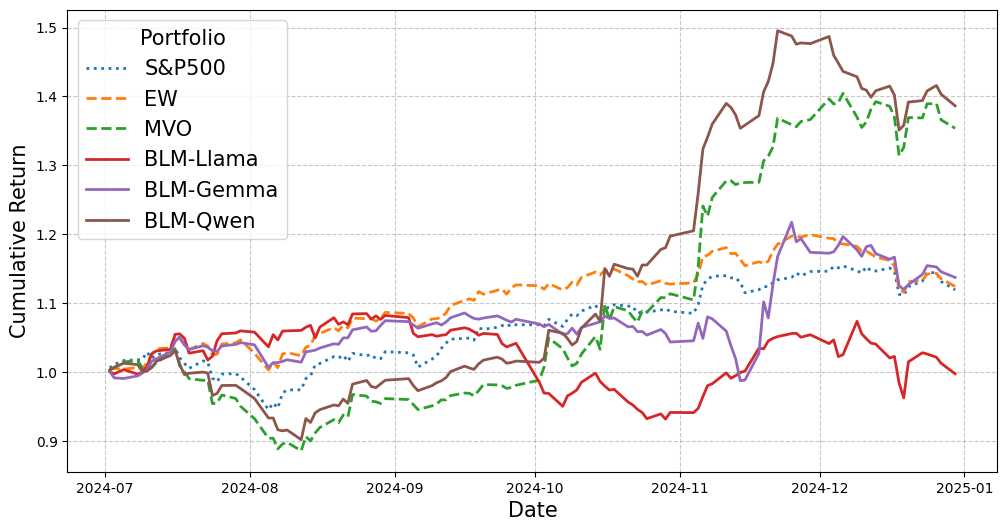

In [8]:
# Plot cumulative returns
plt.figure(figsize=(12, 6)) # 12, 8

# Define different linestyles for each portfolio
linestyles = {
    'S&P500': ':',
    'EW': '--', 
    'MVO': '--',
    'BLM-Llama': '-',
    'BLM-Gemma': '-',
    'BLM-Qwen': '-',  
}

# Calculate and plot cumulative returns for each portfolio
for name, returns in portfolios.items():
    cum_ret = (1 + returns).cumprod()
    plt.plot(pd.to_datetime(llama_returns['Date']), cum_ret, 
             label=name, linewidth=2, linestyle=linestyles[name])

# Customize plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Cumulative Return', fontsize=15)
plt.legend(title='Portfolio', loc='upper left', fontsize=15, title_fontsize=15)
plt.xticks(rotation=0)

# Format dates on x-axis
plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.savefig('cumulative_returns.pdf')
plt.show()
